In [290]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from skimage.measure import ransac
from skimage.measure import structural_similarity as ssim
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.transform import warp
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform, AffineTransform

from utils.training import *
from utils.align import *
from utils.renderer import *

%matplotlib inline

In [291]:
# debug
#target_filename = 'train_2080'
#target_filename = 'train_2078' # primary fuzzy failed
#target_filename = 'train_10483'

target_filename = 'train_17173' #cloud
#target_filename = 'train_18173'
jpg_filename = train_jpg(target_filename)
tiff_filename = train_tif(target_filename)

#target_filename = 'file_12752'
#jpg_filename = test_jpg(target_filename)
#tiff_filename = test_tif(target_filename)


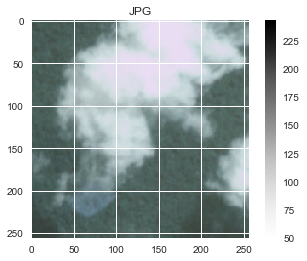

In [292]:
# train_17173 has JPG and TIF mis-aligned
show_jpg(jpg_filename)

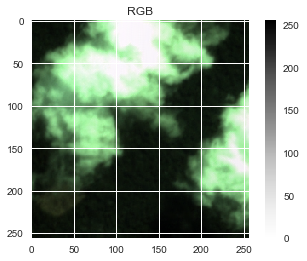

In [293]:
show_tiff_rgb(tiff_filename)

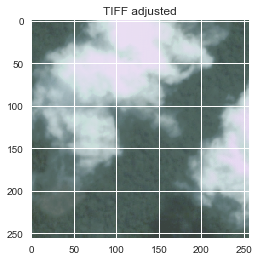

In [294]:
jpg_img_raw = cv2.imread(jpg_filename)
tif_img_raw = cv2.imread(tiff_filename, cv2.IMREAD_UNCHANGED)

im_tif_adjusted = match_color_curve_tif2jpg(tif_img_raw, jpg_img_raw)
plt.title('TIFF adjusted')
plt.imshow(im_tif_adjusted)


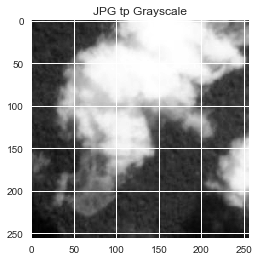

In [295]:
jpg_img_raw = cv2.imread(jpg_filename)

jpg_gray = cv2.cvtColor(jpg_img_raw,cv2.COLOR_BGR2GRAY).astype(np.uint8)
plt.title('JPG tp Grayscale')
plt.imshow(jpg_gray, cmap=plt.cm.gray)

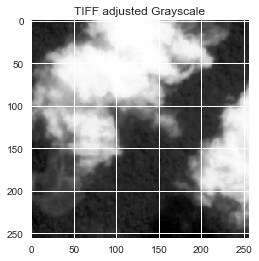

In [296]:
tif_gray = cv2.cvtColor(im_tif_adjusted,cv2.COLOR_BGR2GRAY).astype(np.uint8)
plt.title('TIFF adjusted Grayscale')
plt.imshow(tif_gray, cmap=plt.cm.gray)

In [297]:
number_of_keypoints = 100
#min_number_of_matching_keypoints = 30

# Initialize ORB
# This number of keypoints is large enough for robust results, 
# but low enough to run quickly. 
orb = ORB(n_keypoints=number_of_keypoints, fast_threshold=0.05)
# Detect keypoints
orb.detect_and_extract(jpg_gray)
keypoints_jpg = orb.keypoints
descriptors_jpg = orb.descriptors

orb2 = ORB(n_keypoints=number_of_keypoints, fast_threshold=0.05)
orb2.detect_and_extract(tif_gray)
keypoints_tif = orb2.keypoints
descriptors_tif = orb2.descriptors



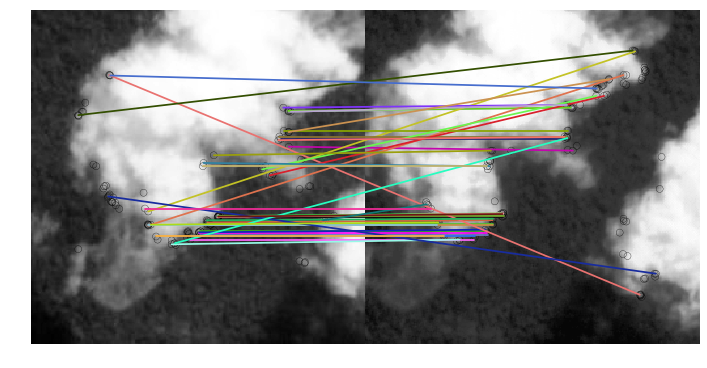

In [298]:


# Match descriptors between left/right images and the center
matches = match_descriptors(descriptors_jpg, descriptors_tif, cross_check=True)

from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, jpg_gray, tif_gray, keypoints_jpg, keypoints_tif, matches)

ax.axis('off');

To filter out the false matches, we apply RANdom SAmple Consensus (RANSAC), a powerful method of rejecting outliers available in skimage.transform.ransac. The transformation is estimated using an iterative process based on randomly chosen subsets, finally selecting the model which corresponds best with the majority of matches.

[False False False False False  True False  True  True  True False False
  True False False False False False  True False False False False False
 False  True  True False False False False False False False False False
 False False False False False  True False False]
('number of matches', 9)
44


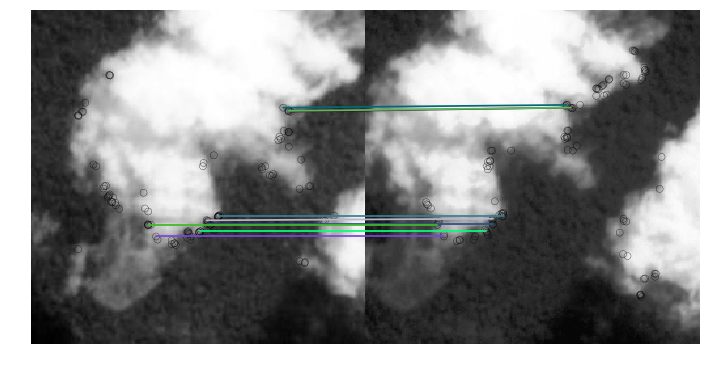

In [299]:
# Select keypoints from
#   * source (image to be registered)
#   * target (reference image)
src = keypoints_jpg[matches[:, 0]][:, ::-1]
dst = keypoints_tif[matches[:, 1]][:, ::-1]

model_robust, inliers = ransac((src, dst), 
                                AffineTransform,
                                min_samples=4, 
                                residual_threshold=1, 
                                max_trials=300)

print (inliers)
print("number of matches", np.sum(inliers))
print(inliers.shape[0])

if inliers is not None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    plot_matches(ax, jpg_gray, tif_gray, keypoints_jpg, keypoints_tif, matches[inliers])
    ax.axis('off');
else:
    print('no matching keypoint. image are definitely not correlated!')

In [300]:
print(model_robust)
print(model_robust.rotation)
print(model_robust.shear)

-0.00398891546111
0.0188486272725


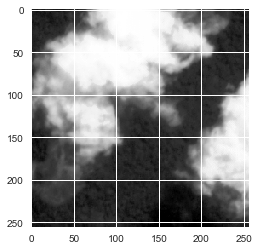

In [301]:
plt.imshow(tif_gray, cmap=plt.cm.gray)

In [302]:
print(model_robust)

(256L, 256L)


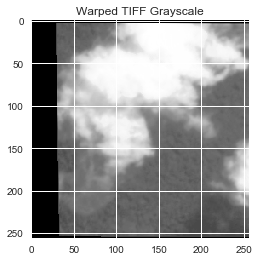

In [303]:
warped_tiff = warp(tif_gray, model_robust)
plt.title('Warped TIFF Grayscale')
plt.imshow(warped_tiff, cmap=plt.cm.gray)
print(warped_tiff.shape)

In [304]:
warped_tiff_full = warp(tif_img_raw, model_robust)
print(warped_tiff_full.shape)

(256L, 256L, 4L)


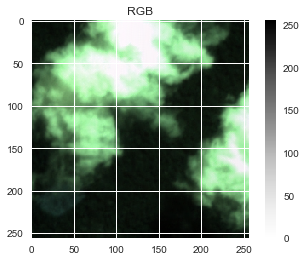

In [305]:
show_tiff_image_data(tif_img_raw)

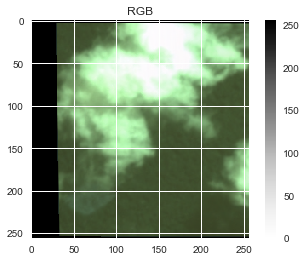

In [306]:
show_tiff_image_data(warped_tiff_full)